In [144]:
from ase.units import Hartree
import numpy as np
import matplotlib.pyplot as plt

from mec_sandia.gaussians import discrete_gaussian_wavepacket, _calc_kinetic_energy

In [145]:
def continuous_1d_gaussian(ks, sigma):
    return np.exp(-np.sum(ks**2.0, axis=1)/(2*sigma**2.0))/(np.sqrt(2*np.pi)*sigma)

In [146]:
ecut_ha = 50
ecut_ev = 50 * Hartree
print(f"{ecut_ha} [Ha] = {ecut_ev} [eV]")
box_length = 15
sigma_k = 4
ke_integral = sigma_k**2.0 / 2
kproj = np.array([0])
print(2*np.pi/box_length)

50 [Ha] = 1360.5693012183622 [eV]
0.41887902047863906


There seem to be a few options of where to put the factor of $\Delta k = 2\pi / L$ factor in the definition of the wavepacket. The first is what we've been doing and seems most natural in our context
$$
|\psi \rangle  = \frac{1}{\mathcal{N}_1} \sum_k e^{-k^2/4\sigma_k^2}|k\rangle
$$
we normalize the wavepacket
$$
\langle \psi | \psi \rangle = 1 \rightarrow \mathcal{N}_1 = \sum_k e^{-k^2/4\sigma_k^2}|k\rangle.
$$
To compute a discretization error (sum vs integral) we can use the definitions
$$
\frac{1}{\Delta k}\sum_k \Delta k e^{-k^2/2\sigma_k^2} \rightarrow \frac{1}{\Delta k} \int dk e^{-k^2/2\sigma_k^2} \rightarrow \mathcal{N}_1 \rightarrow \sigma_k \sqrt{2\pi} / \Delta k,
$$
Alternatively we could write
$$
|\psi \rangle  = \frac{1}{\mathcal{N}_2}\sum_k \Delta k \ e^{-k^2/4\sigma_k^2}|k\rangle
$$
then
$$
\mathcal{N}_2 \rightarrow \sigma_k \sqrt{2\pi}\Delta k
$$
or also
$$
|\psi \rangle  = \sum_k \sqrt{\Delta k} \ e^{-k^2/4\sigma_k^2}|k\rangle
$$
then
$$
\mathcal{N}_3 \rightarrow \sigma_k \sqrt{2\pi}
$$

the `discrete_gaussian_wavepacket` takes the first route and does not include any $\Delta k$ factors in the definition of the wavepacket. The `norm` factor returned is $\sum_k e^{-k^2/2\sigma^2}$. When plotting these Gaussian wavepackets we might want to compare to the continuous variant

$$
p(k) = e^{-k^2/2\sigma^2}/\sqrt{2\pi}\sigma\\
\int p(k) dk = 1 
$$

to ensure the discrete version lie on the same line we should divide the probablility distribution $\psi_k^2/\Delta k$, where $\psi_k$ are the amplitudes (returned as `gaussian` below).

N1 = 1.7864876827193366, N2 = 31.499219864761805, N3 = 10.026513090030528, integral = 10.026513098524001
N1 = 2.526475104056427, N2 = 15.749609859348604, N3 = 10.026513043536722, integral = 10.026513098524001
N1 = 3.094287419372653, N2 = 10.49973985859782, N3 = 10.026512998049048, integral = 10.026513098524001
N1 = 3.57297534246898, N2 = 7.874804864940465, N3 = 10.026512961115042, integral = 10.026513098524001
N1 = 4.892497975429451, N2 = 4.1998959180609265, N3 = 10.026512937463055, integral = 10.026513098524001
N1 = 12.632375419490858, N2 = 0.6299843843208973, N3 = 10.026512883537514, integral = 10.026513098524001


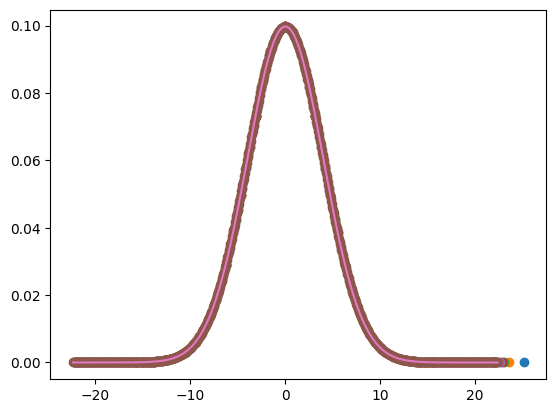

In [207]:
from matplotlib.pyplot import box
ecut = 1000
pk = continuous_1d_gaussian(grid, sigma_k)
for bl in [2, 4, 6, 8, 15, 100]:
    gaussian, grid, norm = discrete_gaussian_wavepacket(ecut_hartree=ecut, box_length=bl, sigma=sigma_k, ndim=1)
    dk = 2*np.pi / bl
    N2 = dk**2.0 * norm**2.0
    N3 = dk * norm**2.0 
    print(f"N1 = {norm}, N2 = {N2}, N3 = {N3}, integral = {sigma_k*np.sqrt(2*np.pi)}")
    plt.plot(grid, gaussian**2.0/dk, marker="o", lw=0)
plt.plot(grid, continuous_1d_gaussian(grid, sigma_k), label="continuous")

The kinetic energy should converge to $\sigma_k$, for a $k_\mathrm{proj}=0$ rapidly with $L$ (grid spacing $\sim 2\pi/L$). Note everything is independently normalized here so it doesn't matter where we put the $\Delta k$ for observables naturally.

In [216]:
from matplotlib.pyplot import box
from mec_sandia.gaussians import kinetic_energy
ecut = 10000
pk = continuous_1d_gaussian(grid, sigma_k)
for bl in [1, 2, 3, 4, 5]:
    dk = 2*np.pi / bl
    ke = kinetic_energy(ecut, bl, sigma_k)
    print(f"L={bl} KE(sum)={ke}, KE(integral) = {sigma_k**2/2} dKE(sum-integral) = {ke-sigma_k**2.0/2}")

L=1 KE(sum)=7.914179146621995, KE(integral) = 8.0 dKE(sum-integral) = -0.08582085337800471
L=2 KE(sum)=7.999999999987032, KE(integral) = 8.0 dKE(sum-integral) = -1.2968293106041529e-11
L=3 KE(sum)=7.999999999999999, KE(integral) = 8.0 dKE(sum-integral) = -8.881784197001252e-16
L=4 KE(sum)=8.0, KE(integral) = 8.0 dKE(sum-integral) = 0.0
L=5 KE(sum)=8.0, KE(integral) = 8.0 dKE(sum-integral) = 0.0


Let's take another look at the dependence on $\sigma_k$

Text(0.5, 1.0, 'Compare convergence to apprx. formula')

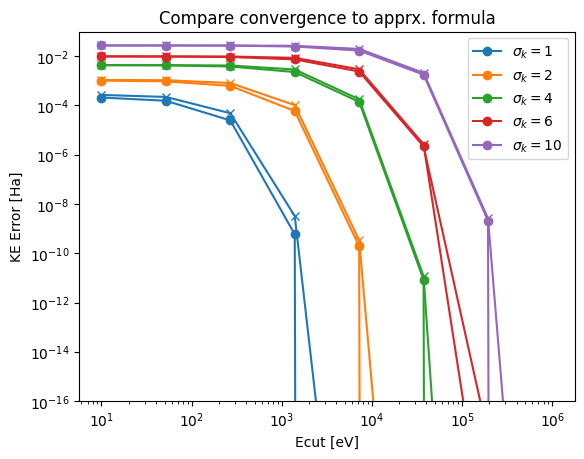

In [244]:
box_length = 15
ecut_ev = np.logspace(1, 6, 8)
mass_proj = 1836
prefactor = 1.0 / mass_proj
from mec_sandia.gaussians import estimate_error_kinetic_energy
for isk, sigma_k in enumerate([1, 2, 4, 6, 10]):
    deltas = []
    deltas_approx = []
    for ec in ecut_ev:
        ecut_ha = ec / Hartree
        ke = kinetic_energy(ecut_ha, box_length, sigma_k)
        ke_int = sigma_k**2/2
        deltas.append(prefactor * np.abs(ke-ke_int))
        # magic factor of 0.5 
        kcut = 0.5*(2*ecut_ha)**0.5
        ke_err_apprx = prefactor*estimate_error_kinetic_energy(kcut, sigma_k)
        deltas_approx.append(ke_err_apprx)
    plt.plot(ecut_ev, deltas, marker="o", color=f"C{isk}", label=f"$\sigma_k = {sigma_k}$")
    plt.plot(ecut_ev, deltas_approx, marker="x", color=f"C{isk}")
plt.legend()
plt.ylim([1e-16, 1e-1])
plt.xlabel("Ecut [eV]")
plt.ylabel("KE Error [Ha]")
plt.xscale("log")
plt.yscale("log")
plt.title("Compare convergence to apprx. formula")
